# Before running this notebook, you need to finish the "preprocess_waymo" notebook first

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import sys
sys.path.append('../src/')

import utils.utils as utils
import utils.dataloader_utils as dataloader_utils
import utils.train_utils as train_utils

import json
from tqdm import tqdm
import gc
from copy import deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
# You need GPU to run this notebook
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Step 1: Load Data

In [6]:
BATCH_SIZE = 1024
num_points_in_one_traj = 51
object_type = 'cyclist' 

In [ ]:
if object_type == 'vehicle':
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_select_non_outlier_indicies.json', "r") as read_file:
        idx_trajs_select = json.load(read_file)

    list_dataset = dataloader_utils.generate_selected_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_trajs_select)
    start_idx_dataset = dataloader_utils.generate_selected_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json')
    combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))
else:
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_outlier_indicies.json', "r") as read_file:
        idx_outlier = json.load(read_file)
        
    list_dataset = dataloader_utils.generate_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_outlier)
    start_idx_dataset = dataloader_utils.generate_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json', idx_outlier)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type = 'agt_traj')
dataProcessor.load_process(shuffle = False)

print(dataProcessor.loaded_dataset.__len__())

(622, 51) (622, 102) (622, 51) (622, 51) (622, 51, 2, 2)


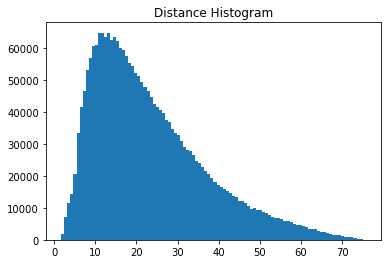

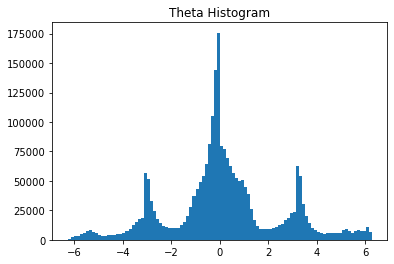

In [8]:
# Let's have a first insight, how distance and angle in polar coordinate distributed
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

d_all = np.zeros((list_dataset.__len__(), num_points_in_one_traj))
theta_all = np.zeros((list_dataset.__len__(), num_points_in_one_traj))    
    
start_batch_idx = 0

for times, agt_traj, d_norm, theta, R_ego_to_map in dataProcessor.loaded_dataset:
    batch_size = times.shape[0]    
    d_all[start_batch_idx:start_batch_idx+batch_size] = d_norm
    theta_all[start_batch_idx:start_batch_idx+batch_size] = theta
    start_batch_idx = start_batch_idx+batch_size
    
ax1.hist(d_all.reshape(-1), bins = 100)
ax1.set_title('Distance Histogram')
ax2.hist(theta_all.reshape(-1), bins = 100)
ax2.set_title('Theta (Alpha) Histogram')
print(times.shape, agt_traj.shape, d_norm.shape, theta.shape, R_ego_to_map.shape)

## Step 2: Empirical Bayes Analysis for Agent Trajectory

In [9]:
# longer trajectories need more epochs
EPOCHS = 50

# longer trajectories need lower lr, consider using https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay
lr = 5e-3

In [ ]:
losses = []
best_losses = []
best_epoch_losses = []
best_epochs = []
bic_scores = []
aic_scores = []
A_list, B_list = [], []
optimizers_ser = []
t_scale_factor = (num_points_in_one_traj-1) / 10 # The time duration of one trajectory, for scaling time to interval (0,1)
log_root_dir = 'logs/gradient_tape/' + object_type + '/agt_xy_polar_plus_const_' + str(num_points_in_one_traj)
degrees = np.linspace(1, 8, 8, dtype=np.int16) # Analyse polynomials from degree 1 to 8

for i_d, deg in enumerate(degrees):
    print('Analysing Deg ',deg)
    model_losses = []
    
    # Initialize optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)   
    optimizers_ser.append(tf.keras.optimizers.serialize(optimizer))
    
    # Initialize all trainable variables
    A = tf.Variable(np.random.randn(2*(deg), 2*(deg))*1e-1, dtype=tf.float64, name='alpha') # Model uncertainty. Note: 0-th parameter (start position) is not interested
    B_d = tf.Variable(np.random.randn(3, 1), dtype=tf.float64, name='beta_d') 
    B_theta = tf.Variable(np.random.randn(1), dtype=tf.float64, name='beta_theta')
    B_const =  tf.Variable(np.random.randn(1), dtype=tf.float64, name='beta_const')
    
    # Initialize tf summary writer
    train_log_dir = log_root_dir + '/deg_' + str(deg)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
    
    # Start Training
    best_epoch_loss, best_epoch, best_alpha, best_beta_d, best_beta_theta, best_beta_const = train_utils.train_agt(alpha=A, beta_d=B_d, beta_theta=B_theta, beta_const = B_const, t_scale_factor = t_scale_factor, degree = deg,
                                                                                                                   opti=optimizer, epochs = EPOCHS, data_loader=dataProcessor.loaded_dataset, model_losses = model_losses, 
                                                                                                                   tf_summary_writer = train_summary_writer, verbose = True, early_stop=False)
            
    # Add loss
    losses.append(model_losses)
    best_epoch_losses.append([best_epoch_loss])
    
    # store the best epoch
    best_epochs.append(best_epoch)
    
    # Compute AIC and BIC
    aic_score, bic_score = utils.compute_AIC_BIC(nll = best_epoch_loss, deg = deg, num_points = num_points_in_one_traj, dof_in_ob = 5)

    bic_scores.append(bic_score)
    aic_scores.append(aic_score)
    
    # Compute the model uncertainty, A_unscaled = np.linalg.inv(scale_mat) @ A_scaled
    A_scale_mat = utils.polyBasisScale(t_scale_factor, deg)
    A_scale_mat = A_scale_mat[1:, 1:]
    A_est = np.linalg.inv(np.kron(np.eye(2), A_scale_mat)) @ best_alpha.numpy()
    A_est = A_est @ A_est.T # This is the unscaled model parameter covariance
    A_list.append(A_est)
    
    # Compute the observation uncertainty and store
    # Note that parameters for observation noise are all reconstructed as they are computed in MVN.
    B_est = {'B_d': (tf.math.softplus(best_beta_d)).numpy(), 'B_theta': (tf.math.softplus(best_beta_theta)).numpy(),'B_const': (tf.math.softplus(best_beta_const)).numpy()} 
    B_list.append(B_est)
    print("Degree: {}, NLL: {}, BIC: {}, AIC: {}".format(deg, model_losses[-1], bic_score, aic_score))

In [39]:
result = utils.calculate_result(degrees, bic_scores, aic_scores, A_list, B_list, best_epoch_losses, best_epochs, lr, optimizers_ser, EPOCHS, BATCH_SIZE)

In [43]:
utils.save_result(folder_dir =log_root_dir, file_name='result_summary', result=result)

with open(log_root_dir + '/' + 'optimizers' + '.json', "w") as write_file:
    json.dump(optimizers_ser, write_file, cls=NumpyEncoder)

## Test: Plot the sigma_d with distance

Text(0, 0.5, '[m]')

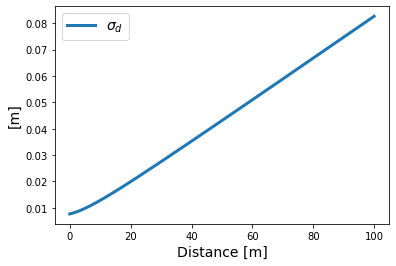

In [45]:
fig, ax = plt.subplots()
d = np.linspace(0, 100, 1000)
theta = 0
sigmas_d = []

wd = (result['best_aic_B']['B_d'])
for d_i in d:
    sigma = np.sqrt(wd[0] + wd[1]*d_i + wd[2]* (d_i**2))
    sigmas_d.append(sigma)
ax.plot(d, sigmas_d, label = '${\sigma}_{d}$', linewidth = 3)  
ax.legend(fontsize=14)
ax.set_xlabel("Distance [m]", fontsize=14)
ax.set_ylabel("[m]", fontsize=14)